## Kickstarter Project Exploration

Explore cancer projects from Kickstarter

In [1]:
import os.path as op

import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import ttest_ind

import statsmodels.api as sm

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
with open(op.join(DATA_PROCESSED, 'cancer_project_text.json'), 'r') as f:
    text_data = json.load(f)

This json file comes from `src/data/data_download.py`.

In [4]:
with open(op.join(DATA_PROCESSED, 'cancer_project_data.json'), 'r') as f:
    json_data = json.load(f)

In [5]:
data = pd.DataFrame(json_data)

data = data.drop_duplicates(subset='id')
data = data[data['id'].isin(list(text_data.keys()))]

data['usd_pledged'] = data['usd_pledged'].astype(float)
data['deadline'] = pd.to_datetime(data['deadline'], unit='s')
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data['launched_at'] = pd.to_datetime(data['launched_at'], unit='s')

data.sample(5)

,backers_count,blurb,category_slug,country,created_at,currency,current_currency,deadline,geo_type,goal,id,launched_at,pledged,spotlight,staff_pick,state,status,status_changed_at,url,usd_pledged
342,0,This stage play is a true story about one woma...,theater/plays,US,2016-11-01 02:41:08,USD,USD,2016-12-01 07:18:40,Town,20000,1133022274,2016-11-01 06:18:40,0.0,False,False,GA,failed,1480576720,https://www.kickstarter.com/projects/497611822...,0.000000
396,69,"""Tissue"" is a play about Breast Cancer. Produc...",theater/plays,GB,2014-03-20 11:21:23,GBP,USD,2015-04-01 20:17:48,County,1500,973883863,2015-03-02 21:17:48,1594.0,True,False,England,successful,1427919472,https://www.kickstarter.com/projects/468851424...,2460.472673
41,168,Une ligne complète de vêtements et sous-vêteme...,fashion/apparel,FR,2018-01-16 15:12:03,EUR,USD,2018-04-13 12:38:18,LocalAdmin,20000,1631396661,2018-03-04 13:38:18,20445.0,True,False,Midi-Pyrenees,successful,1523623098,https://www.kickstarter.com/projects/978516628...,25185.084723
174,30,A warm and pleasant environment is a basic req...,design/architecture,SE,2016-03-09 14:01:06,SEK,USD,2016-04-10 07:02:40,Town,2000,1306888674,2016-03-11 08:02:40,4184.0,True,False,Stockholm,successful,1460271764,https://www.kickstarter.com/projects/19327145/...,494.288262
411,2,Trance music cures cancer! Just kidding... Ele...,music/electronic music,US,2012-01-17 16:28:39,USD,USD,2012-03-19 16:49:27,Town,10000,1172933358,2012-01-19 17:49:27,50.0,False,False,MO,failed,1332175767,https://www.kickstarter.com/projects/noizecran...,50.000000


In [6]:
len(json_data), data.shape

(472, (455, 20))

Clean out projects not classified as Success or Fail

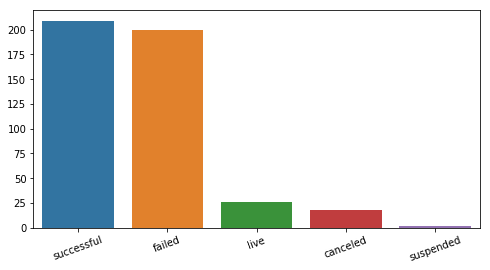

In [7]:
cnt = data['status'].value_counts()
plt.subplots(figsize=(8,4))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

In [8]:
data = data[data['status'].isin(['successful', 'failed'])]
data.shape

(409, 20)

Percent spotlight: 54.09%


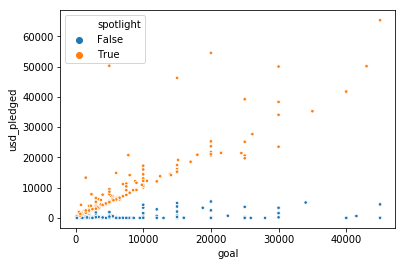

In [9]:
sub_data = data[data['goal'] < 50000]
print(f"Percent spotlight: {sub_data['spotlight'].mean()*100:.2f}%")
sns.scatterplot(sub_data['goal'], sub_data['usd_pledged'], hue=sub_data['spotlight'], s=12)

Welsh's t-test of spotlight (true or false) distributions

What exactly is spotlight? Has a pretty significant correlation with pledged to goal ratio. Doesn't take into account currency conversions but these should be negligible for now.

In [10]:
spotlight_true = sub_data[sub_data['spotlight'] == True]
spotlight_true = (spotlight_true['usd_pledged'] / spotlight_true['goal']).values
spotlight_false = sub_data[sub_data['spotlight'] == False]
spotlight_false = (spotlight_false['usd_pledged'] / spotlight_false['goal']).values

ttest_ind(spotlight_true, spotlight_false, equal_var=False)

Ttest_indResult(statistic=19.276260866752335, pvalue=1.5106371238579e-48)

Percent staff pick: 5.01%


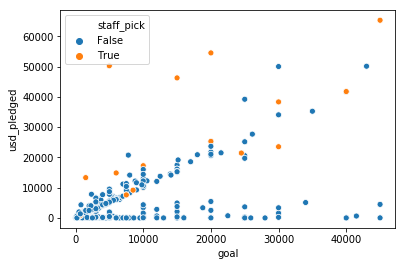

In [11]:
print(f"Percent staff pick: {sub_data['staff_pick'].mean()*100:.2f}%")
sns.scatterplot(sub_data['goal'], sub_data['usd_pledged'], hue=sub_data['staff_pick'])

Welsh's t-test of staff-pick (true or false) distributions

In [12]:
staff_pick_true = sub_data[sub_data['staff_pick'] == True]
staff_pick_true = (staff_pick_true['pledged'] / staff_pick_true['goal']).values
staff_pick_false = sub_data[sub_data['staff_pick'] == False]
staff_pick_false = (staff_pick_false['pledged'] / staff_pick_false['goal']).values

ttest_ind(staff_pick_true, staff_pick_false, equal_var=False)

Ttest_indResult(statistic=2.634838875291475, pvalue=0.01674144505617373)

Popular Country of Origin

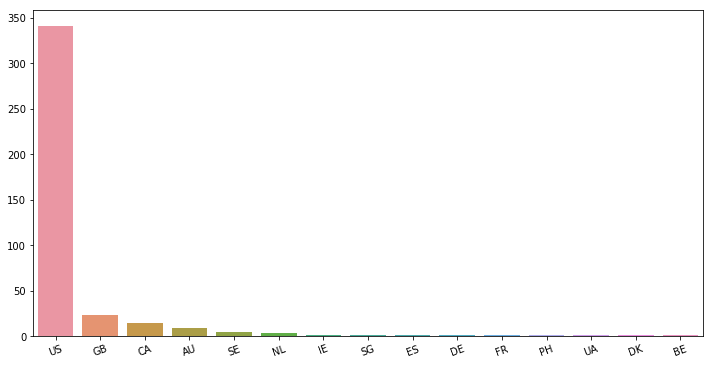

In [13]:
cnt = data['country'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Popular Project Categories

TODO: Aggregate less popular categories into larger supersets.

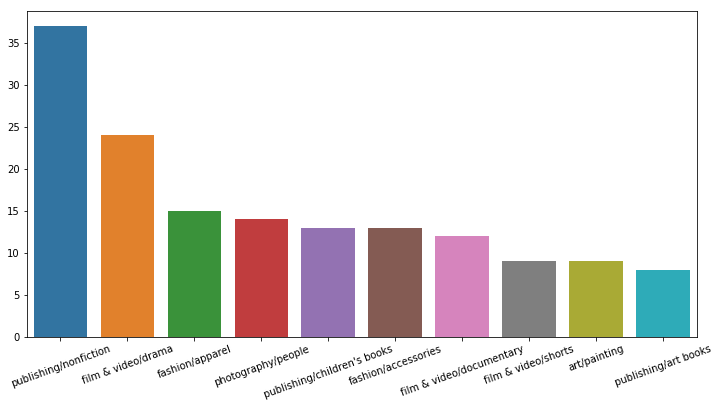

In [14]:
cnt = data['category_slug'].value_counts().nlargest(10)
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Geo Types

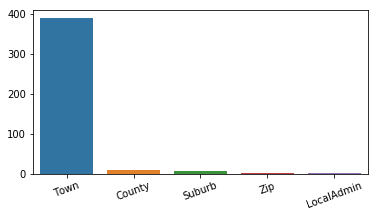

In [15]:
cnt = data['geo_type'].value_counts()
plt.subplots(figsize=(6,3))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Average Duration

In [16]:
pd.Timedelta(np.median(data['deadline'] - data['launched_at']))

Timedelta('30 days 00:00:00')

Maximum Duration

In [17]:
pd.Timedelta(np.max(data['deadline'] - data['launched_at']))

Timedelta('89 days 17:06:15')